In [ ]:
# default_exp tree

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# tree

> Neural Decision Trees

In [ ]:
# export
import numpy as np

from typing import List
import torch.nn as nn
import torch

from sklearn.tree import BaseDecisionTree
from functools import partial

In [ ]:
from cryptotree.polynomials import 

In [ ]:
# export
from sklearn.tree import BaseDecisionTree
from sklearn.base import is_classifier

from typing import Callable
from numpy.polynomial.chebyshev import Chebyshev
from numpy.polynomial import Polynomial
from cryptotree.activations import create_linear_node_comparator

DEFAULT_POLYNOMIAL_DEGREE = 16
DEFAULT_DILATATION_FACTOR = 16
DEFAULT_BOUND = 1.0

class NeuralTreeMaker:
    """Base class of Neural Decision Trees."""
    def __init__(self, 
                 activation: Callable, 
                 create_linear_leaf_matcher: Callable,
                 create_regression_head: Callable,
                 create_classifier_head: Callable,
                 dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND):
        
        activation_fn = lambda x: activation(x * dilatation_factor)
        if use_polynomial:
            domain = [-bound, bound]
            activation_fn_numpy = lambda x: activation_fn(torch.tensor(x))
            self.activation = Chebyshev.interpolate(activation_fn_numpy,deg=polynomial_degree,domain=domain)
            self.coeffs = Polynomial.cast(self.activation).coef
        else:
            self.activation = activation_fn
            self.coeffs = None
            
        self.create_linear_leaf_matcher = create_linear_leaf_matcher
        self.create_regression_head = create_regression_head
        self.create_classifier_head = create_classifier_head
        
    def make_tree(self, tree: BaseDecisionTree):
        if is_classifier(tree):
            create_head = self.create_classifier_head
        else:
            create_head = self.create_regression_head
        neural_tree = NeuralDecisionTree(tree, self.activation, self.create_linear_leaf_matcher, create_head)
        return neural_tree

class NeuralDecisionTree(nn.Module):
    """Base class of Neural Decision Trees."""
    def __init__(self, tree: BaseDecisionTree,
                 activation: Callable,
                 create_linear_leaf_matcher: Callable,
                 create_head: Callable):
        super(NeuralDecisionTree, self).__init__()
        
        self.activation = activation
        
        self.comparator = create_linear_node_comparator(tree)
        self.matcher = create_linear_leaf_matcher(tree)
        
        self.head = create_head(tree)
            
    def forward(self,x):
        comparisons = self.comparator(x)
        comparisons = self.activation(comparisons)
        
        matches = self.matcher(comparisons)
        matches = self.activation(matches)
        
        output = self.head(matches)
        
        return output


In [ ]:
# export
from cryptotree.activations import sigmoid_linear_leaf_matcher, sigmoid_classification_head

def raise_error_wrong_tree(*args,**kwargs):
    raise Exception("Wrong supervised tree used")
    
class SigmoidTreeMaker(NeuralTreeMaker):
    def __init__(self, dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND, eps=0.5):
        
        activation = torch.sigmoid
        create_linear_leaf_matcher = partial(sigmoid_linear_leaf_matcher,eps=eps)
        create_classifier_head = sigmoid_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(activation, 
                 create_linear_leaf_matcher,
                 create_regression_head,
                 create_classifier_head,
                 dilatation_factor,
                 use_polynomial, 
                 polynomial_degree)

In [ ]:
# export
from cryptotree.activations import tanh_linear_leaf_matcher, tanh_classification_head

class TanhTreeMaker(NeuralTreeMaker):
    def __init__(self, dilatation_factor : float = DEFAULT_DILATATION_FACTOR,
                 use_polynomial : bool = False, 
                 polynomial_degree : int = DEFAULT_POLYNOMIAL_DEGREE, bound: float = DEFAULT_BOUND, eps=0.5):
        
        activation = torch.tanh
        create_linear_leaf_matcher = partial(tanh_linear_leaf_matcher,eps=eps)
        create_classifier_head = tanh_classification_head
        create_regression_head = raise_error_wrong_tree
        
        super().__init__(activation, 
                 create_linear_leaf_matcher,
                 create_regression_head,
                 create_classifier_head,
                 dilatation_factor,
                 use_polynomial, 
                 polynomial_degree)

In [ ]:
# export
def check_output_range(m, i, o, threshold=1):
    rows_outside_range = ((torch.abs(o) > threshold).float().sum(dim=1) > 0).numpy()
    idx_outside_range = np.arange(len(rows_outside_range))[rows_outside_range]
    
    assert len(idx_outside_range) == 0, f"""Out of range outputs for module {m}: \n 
    {idx_outside_range} \n
    Rows with outside range : \n
    {o.numpy()[idx_outside_range]}"""

def register_output_check(model, threshold=1):
    for c in model.children():
        if isinstance(c,nn.Linear):
            hook = partial(check_output_range, threshold=threshold)
            c.register_forward_hook(hook)

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)

estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
estimator.fit(X_train, y_train)

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 13 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.2916666641831398 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 0.6637930870056152 else to node 8.
		node=3 test node: go to node 4 if X[:, 3] <= 0.6458333432674408 else to node 5.
			node=4 leaf node.
			node=5 test node: go to node 6 if X[:, 1] <= 0.4583333283662796 else to node 7.
				node=6 leaf node.
				node=7 leaf node.
		node=8 test node: go to node 9 if X[:, 3] <= 0.6875 else to node 12.
			node=9 test node: go to node 10 if X[:, 3] <= 0.6458333432674408 else to node 11.
				node=10 leaf node.
				node=11 leaf node.
			node=12 leaf node.



(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f739cfac190>)

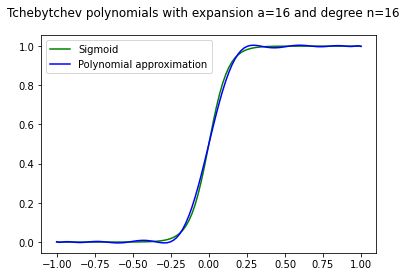

In [ ]:
from cryptotree.polynomials import plot_graph_function_approximation

dilatation_factor = 16
polynomial_degree = 16

plot_graph_function_approximation(torch.sigmoid,dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

In [ ]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)
tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

In [ ]:
# export
def pad_tensor(tensor, target, dim=0, value=0):
    # If the tensor is already at the target size we return it
    if tensor.shape[dim] >= target:
        return tensor
    else:
        shape = list(tensor.shape)
        shape[dim] = target - tensor.shape[dim]

        padding = torch.ones(shape) * value
        output = torch.cat([tensor,padding], dim=dim)
        return output

def pad_neural_tree(neural_tree, n_nodes_max, n_leaves_max):
    w0, b0 = neural_tree.comparator.weight.data.clone(), neural_tree.comparator.bias.data.clone()
    
    # First we pad the output size of the comparator
    neural_tree.comparator = nn.Linear(w0.shape[1], n_nodes_max)
    neural_tree.comparator.weight.data = pad_tensor(w0, n_nodes_max, dim=0)
    neural_tree.comparator.bias.data = pad_tensor(b0, n_nodes_max, dim=0)
    
    w1, b1 = neural_tree.matcher.weight.data.clone(), neural_tree.matcher.bias.data.clone()
    # Then we pad the output and the input size of the matcher
    neural_tree.matcher = nn.Linear(n_nodes_max, n_leaves_max)
    neural_tree.matcher.weight.data = pad_tensor(pad_tensor(w1, n_nodes_max, dim=1), n_leaves_max, dim=0)
    neural_tree.matcher.bias.data = pad_tensor(b1, n_leaves_max, dim=0)
    
    w2, b2 = neural_tree.head.weight.data.clone(), neural_tree.head.bias.data.clone()
    neural_tree.head = nn.Linear(n_leaves_max, w2.shape[0])
    neural_tree.head.weight.data = pad_tensor(w2, n_leaves_max, dim =1)
    neural_tree.head.bias.data = b2

In [ ]:
x = torch.tensor(X_train[0]).float()

comparisons = model.activation(model.comparator(x))
padded_comparisons = model.activation(padded_model.comparator(x))

print(comparisons.sum() == padded_comparisons.sum())

match = model.activation(model.matcher(comparisons))
padded_match = model.activation(padded_model.matcher(padded_comparisons))

print(match, padded_match)

output = model.head(match)
padded_output = padded_model.head(padded_match)

print(output, padded_output)

tensor(False)
tensor([0.2454, 0.5324, 0.1666, 0.0828, 0.1119, 0.0260, 0.0389],
       grad_fn=<AddBackward0>) tensor([0.2454, 0.5324, 0.1666, 0.0828, 0.1119, 0.0260, 0.0389, 0.5000, 0.5000,
        0.5000, 0.5000], grad_fn=<AddBackward0>)
tensor([ 0.0373,  0.2490, -0.1505], grad_fn=<AddBackward0>) tensor([-1.1161, -0.7808, -1.3460], grad_fn=<AddBackward0>)


In [ ]:
model.head.weight.data, model.head.bias.data

(tensor([[ 0.0000, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024],
         [-0.8293, -0.0488, -0.8293, -0.8049, -0.8293, -0.8049, -0.8293],
         [-1.0000, -1.0000, -0.9268, -1.0000, -0.9268, -1.0000, -0.1463]]),
 tensor([0.9024, 0.8293, 1.0000]))

In [ ]:
padded_model.head.weight.data, padded_model.head.bias.data

(tensor([[ 0.0000, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.8293, -0.0488, -0.8293, -0.8049, -0.8293, -0.8049, -0.8293,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-1.0000, -1.0000, -0.9268, -1.0000, -0.9268, -1.0000, -0.1463,  0.0000,
           0.0000,  0.0000,  0.0000]]),
 tensor([-0.2510, -0.2005, -0.1955]))

In [ ]:
padded_model.head(padded_match)

tensor([-1.1161, -0.7808, -1.3460], grad_fn=<AddBackward0>)

In [ ]:
padded_model.head

Linear(in_features=11, out_features=3, bias=True)

In [ ]:
n_nodes_max = 10
n_leaves_max = 11

x = torch.tensor(X_train).float()
tree = estimator

model = sigmoid_tree_maker.make_tree(tree)
pad_neural_tree(model, n_nodes_max, n_leaves_max)
model.eval()

with torch.no_grad():
    output = model(x)
pred = output.argmax(dim=1)
y = estimator.predict(X_train)
(pred == torch.tensor(y)).float().mean()

tensor(0.9464)

In [ ]:
x = torch.tensor(X_train).float()
tree = estimator
model = tanh_tree_maker.make_tree(tree)
register_output_check(model, threshold=1)

model.eval()

with torch.no_grad():
    output = model(x)
pred = output.argmax(dim=1)
y = estimator.predict(X_train)
(pred == torch.tensor(y)).float().mean()

In [ ]:
# export
class NeuralRandomForest(nn.Module):
    def __init__(self, trees: List[BaseDecisionTree],
                 tree_maker: NeuralTreeMaker, 
                 weights: torch.Tensor = None, trainable_weights:bool = False,
                 bias: torch.Tensor = None, trainable_bias:bool = False):
        
        super(NeuralRandomForest, self).__init__()
        
        self.n_trees = len(trees)
        self.activation = tree_maker.activation
        
        # First we need to create the neural trees
        neural_trees = []
        n_nodes = []
        n_leaves = []
        for tree in trees:
            neural_tree = tree_maker.make_tree(tree)
            n_nodes.append(neural_tree.comparator.weight.data.shape[0])
            n_leaves.append(neural_tree.matcher.weight.data.shape[0])
            neural_trees.append(neural_tree)
        
        # Then we pad our neural trees according to the biggest tree in the forest
        n_nodes_max = max(n_nodes)
        n_leaves_max = max(n_leaves)
        
        for neural_tree in neural_trees:
            pad_neural_tree(neural_tree, n_nodes_max, n_leaves_max)
            
        self.neural_trees = neural_trees
        
        # Then we create the parameters for the Neural Random Forest
        comparators = [neural_tree.comparator.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        comparator = torch.cat(comparators, dim=-1)
        comparator = comparator.permute(1,0,2)
        comparator = nn.Parameter(comparator)
        self.register_parameter("comparator", comparator)

        comparator_bias = [neural_tree.comparator.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        comparator_bias = torch.cat(comparator_bias, dim=-1)
        comparator_bias = nn.Parameter(comparator_bias)
        self.register_parameter("comparator_bias", comparator_bias)

        matchers = [neural_tree.matcher.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        matcher = torch.cat(matchers, dim=-1)
        matcher = nn.Parameter(matcher)
        self.register_parameter("matcher", matcher)

        matcher_bias = [neural_tree.matcher.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        matcher_bias = torch.cat(matcher_bias, dim=-1)
        matcher_bias = nn.Parameter(matcher_bias)
        self.register_parameter("matcher_bias",matcher_bias)

        heads = [neural_tree.head.weight.data.unsqueeze(-1) for neural_tree in neural_trees]
        head = torch.cat(heads, dim=-1)
        head = nn.Parameter(head)
        self.register_parameter("head", head)

        head_bias = [neural_tree.head.bias.data.unsqueeze(-1) for neural_tree in neural_trees]
        head_bias = torch.cat(head_bias, dim=-1)
        head_bias = nn.Parameter(head_bias)
        self.register_parameter("head_bias", head_bias)
        
        if not torch.is_tensor(weights):
            weights = torch.ones(self.n_trees) * (1. / self.n_trees)
            
        if trainable_weights:
            weights = nn.Parameter(weights)
            self.register_parameter("weights", weights)
        else:
            self.register_buffer("weights", weights)
            
        if not torch.is_tensor(bias):
            c = neural_tree.head.weight.data.shape[0]
            bias = torch.zeros(c)
            
        if trainable_bias:
            bias = nn.Parameter(bias)
            self.register_parameter("bias",bias)
        else:
            self.register_buffer("bias",bias)
        
    def forward(self, x):
        comparisons = torch.einsum("kj,jil->kil",x,self.comparator) + self.comparator_bias.unsqueeze(0)
        comparisons = self.activation(comparisons)
        
        matches = torch.einsum("kjl,ijl->kil",comparisons, self.matcher) + self.matcher_bias
        matches = self.activation(matches)
        
        outputs = torch.einsum("kjl,cjl->kcl",matches,self.head) + self.head_bias
        outputs = (outputs * self.weights.expand_as(outputs)).sum(dim=-1)
        outputs = outputs + self.bias.expand_as(outputs)
        
        return outputs

In [ ]:
for param in neural_rf.parameters():
    print(param)

Parameter containing:
tensor([[[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 1., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 0.,  ..., 0., 1., 0.],
         [0., 1., 1.,  ..., 1., 0., 1.],
         [1., 0., 0.,  ..., 0., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
trees = rf.estimators_
make_tree = sigmoid_tree_maker.make_tree

In [ ]:
neural_rf = NeuralRandomForest(trees, make_tree)
neural_trees = neural_rf.neural_trees

In [ ]:
neural_rf.register_parameter("comparator",nn.Parameter(comparator))

In [ ]:
i = 1

In [ ]:
comparisons = torch.einsum("kj,jil->kil",x,comparator) + comparator_bias.unsqueeze(0)
comparisons = sigmoid_tree_maker.activation(comparisons)
comparisons[:,:,i]

tensor([[ 1.0034,  0.1942,  0.1382,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.9541,  0.0110,  0.0770,  ...,  0.5000,  0.5000,  0.5000],
        [ 1.0032,  0.8935,  0.7826,  ...,  0.5000,  0.5000,  0.5000],
        ...,
        [ 0.8058, -0.0034,  0.1053,  ...,  0.5000,  0.5000,  0.5000],
        [ 1.0044,  0.9541,  1.0042,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.0110, -0.0023, -0.0042,  ...,  0.5000,  0.5000,  0.5000]])

In [ ]:
neural_tree = neural_trees[i]
comparison = neural_tree.activation(neural_tree.comparator(x))
comparison

tensor([[ 1.0034,  0.1942,  0.1382,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.9541,  0.0110,  0.0770,  ...,  0.5000,  0.5000,  0.5000],
        [ 1.0032,  0.8935,  0.7826,  ...,  0.5000,  0.5000,  0.5000],
        ...,
        [ 0.8058, -0.0034,  0.1053,  ...,  0.5000,  0.5000,  0.5000],
        [ 1.0044,  0.9541,  1.0042,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.0110, -0.0023, -0.0042,  ...,  0.5000,  0.5000,  0.5000]],
       grad_fn=<AddBackward0>)

In [ ]:
matches = torch.einsum("kjl,ijl->kil",comparisons, matcher) + matcher_bias
matches = sigmoid_tree_maker.activation(matches)
matches[:,:,i]

tensor([[ 0.2787,  0.4121,  0.1801,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2988,  0.5473,  0.3143,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2788, -0.0041, -0.0035,  ...,  0.5000,  0.5000,  0.5000],
        ...,
        [ 0.3619,  0.4505,  0.2877,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2784,  0.0014,  0.0014,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.7155,  0.2871,  0.0232,  ...,  0.5000,  0.5000,  0.5000]])

In [ ]:
match = neural_tree.activation(neural_tree.matcher(comparison))
match

tensor([[ 0.2787,  0.4121,  0.1801,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2988,  0.5473,  0.3143,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2788, -0.0041, -0.0035,  ...,  0.5000,  0.5000,  0.5000],
        ...,
        [ 0.3619,  0.4505,  0.2877,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.2784,  0.0014,  0.0014,  ...,  0.5000,  0.5000,  0.5000],
        [ 0.7155,  0.2871,  0.0232,  ...,  0.5000,  0.5000,  0.5000]],
       grad_fn=<AddBackward0>)

In [ ]:
outputs.shape

torch.Size([112, 3, 100])

In [ ]:
neural_rf = NeuralRandomForest(trees, sigmoid_tree_maker)

In [ ]:
neural_rf(x)

tensor([[-0.1402,  0.1001, -0.2013],
        [-0.2012,  0.1106, -0.3262],
        [-0.1494, -0.1972,  0.2097],
        [ 0.5272,  0.0168, -0.1169],
        [-0.1579, -0.1808,  0.1320],
        [ 0.4465,  0.0636, -0.1217],
        [ 0.4899,  0.0305, -0.1225],
        [-0.1345,  0.0597, -0.3621],
        [-0.0809, -0.1126,  0.2007],
        [-0.1945, -0.2536,  0.2034],
        [-0.0963,  0.0012, -0.0192],
        [-0.1466, -0.1899,  0.1887],
        [-0.1759,  0.1145, -0.3342],
        [-0.2200, -0.2863,  0.2222],
        [-0.0732,  0.0448, -0.0332],
        [-0.1817,  0.1039, -0.3493],
        [-0.0499, -0.0155,  0.1055],
        [-0.0843,  0.0046,  0.0230],
        [-0.0596, -0.0056, -0.0798],
        [-0.0809, -0.0754,  0.1282],
        [-0.1394,  0.0328, -0.1328],
        [-0.0975, -0.1216,  0.1788],
        [-0.0930,  0.0592, -0.1023],
        [ 0.5081,  0.0297, -0.1172],
        [-0.0513, -0.0619,  0.1489],
        [-0.1655,  0.1112, -0.2705],
        [-0.1889,  0.1166, -0.3364],
 

In [ ]:
outputs = torch.einsum("kjl,cjl->kcl",matches,head) + head_bias
outputs[:,:,i]

tensor([[-0.2094, -0.1543, -0.3201],
        [-0.4081, -0.2345, -0.5845],
        [-0.2032, -0.4010,  0.1009],
        [ 0.6389,  0.0795, -0.0686],
        [-0.1821, -0.3839,  0.1545],
        [ 0.4033,  0.0597, -0.1725],
        [ 0.6507,  0.0890, -0.0590],
        [-0.2741, -0.1713, -0.5795],
        [-0.0766, -0.2923,  0.0682],
        [-0.2648, -0.4516,  0.0684],
        [-0.1622, -0.2518, -0.2379],
        [-0.1422, -0.3507,  0.0347],
        [-0.3523, -0.2080, -0.5895],
        [-0.3145, -0.4896,  0.0278],
        [-0.0635, -0.1677, -0.0499],
        [-0.3714, -0.2138, -0.6152],
        [ 0.0281, -0.1779,  0.1180],
        [-0.1954, -0.2939, -0.1929],
        [-0.0440, -0.1530, -0.2276],
        [-0.0129, -0.2310,  0.1271],
        [-0.3489, -0.3283, -0.2959],
        [-0.1016, -0.3155,  0.1315],
        [-0.0580, -0.1276, -0.1269],
        [ 0.6400,  0.0797, -0.0675],
        [-0.0152, -0.2325, -0.0283],
        [-0.4153, -0.2643, -0.5918],
        [-0.4487, -0.2269, -0.6289],
 

In [ ]:
neural_tree.head(match)

tensor([[-0.2094, -0.1543, -0.3201],
        [-0.4081, -0.2345, -0.5845],
        [-0.2032, -0.4010,  0.1009],
        [ 0.6389,  0.0795, -0.0686],
        [-0.1821, -0.3839,  0.1545],
        [ 0.4033,  0.0597, -0.1725],
        [ 0.6507,  0.0890, -0.0590],
        [-0.2741, -0.1713, -0.5795],
        [-0.0766, -0.2923,  0.0682],
        [-0.2648, -0.4516,  0.0684],
        [-0.1622, -0.2518, -0.2379],
        [-0.1422, -0.3507,  0.0347],
        [-0.3523, -0.2080, -0.5895],
        [-0.3145, -0.4896,  0.0278],
        [-0.0635, -0.1677, -0.0499],
        [-0.3714, -0.2138, -0.6152],
        [ 0.0281, -0.1779,  0.1180],
        [-0.1954, -0.2939, -0.1929],
        [-0.0440, -0.1530, -0.2276],
        [-0.0129, -0.2310,  0.1271],
        [-0.3489, -0.3283, -0.2959],
        [-0.1016, -0.3155,  0.1315],
        [-0.0580, -0.1276, -0.1269],
        [ 0.6400,  0.0797, -0.0675],
        [-0.0152, -0.2325, -0.0283],
        [-0.4153, -0.2643, -0.5918],
        [-0.4487, -0.2269, -0.6289],
 

In [ ]:
n_trees = len(trees)

weights = torch.ones(n_trees) * (1. / n_trees)
bias = torch.zeros(neural_tree.head.weight.data.shape[0])

In [ ]:
outputs = (outputs * weights).sum(dim=-1)

In [ ]:
with torch.no_grad():
    preds = neural_rf(x).argmax(dim=1).numpy()

In [ ]:
y = rf.predict(X_train)

In [ ]:
(preds == y).mean()

0.9642857142857143

In [ ]:
outputs + bias.expand_as(outputs)

tensor([[-0.1402,  0.1001, -0.2013],
        [-0.2012,  0.1106, -0.3262],
        [-0.1494, -0.1972,  0.2097],
        [ 0.5272,  0.0168, -0.1169],
        [-0.1579, -0.1808,  0.1320],
        [ 0.4465,  0.0636, -0.1217],
        [ 0.4899,  0.0305, -0.1225],
        [-0.1345,  0.0597, -0.3621],
        [-0.0809, -0.1126,  0.2007],
        [-0.1945, -0.2536,  0.2034],
        [-0.0963,  0.0012, -0.0192],
        [-0.1466, -0.1899,  0.1887],
        [-0.1759,  0.1145, -0.3342],
        [-0.2200, -0.2863,  0.2222],
        [-0.0732,  0.0448, -0.0332],
        [-0.1817,  0.1039, -0.3493],
        [-0.0499, -0.0155,  0.1055],
        [-0.0843,  0.0046,  0.0230],
        [-0.0596, -0.0056, -0.0798],
        [-0.0809, -0.0754,  0.1282],
        [-0.1394,  0.0328, -0.1328],
        [-0.0975, -0.1216,  0.1788],
        [-0.0930,  0.0592, -0.1023],
        [ 0.5081,  0.0297, -0.1172],
        [-0.0513, -0.0619,  0.1489],
        [-0.1655,  0.1112, -0.2705],
        [-0.1889,  0.1166, -0.3364],
 

In [ ]:
(outputs * weights.expand_as(outputs)).sum(dim=-1)

tensor([[-0.1402,  0.1001, -0.2013],
        [-0.2012,  0.1106, -0.3262],
        [-0.1494, -0.1972,  0.2097],
        [ 0.5272,  0.0168, -0.1169],
        [-0.1579, -0.1808,  0.1320],
        [ 0.4465,  0.0636, -0.1217],
        [ 0.4899,  0.0305, -0.1225],
        [-0.1345,  0.0597, -0.3621],
        [-0.0809, -0.1126,  0.2007],
        [-0.1945, -0.2536,  0.2034],
        [-0.0963,  0.0012, -0.0192],
        [-0.1466, -0.1899,  0.1887],
        [-0.1759,  0.1145, -0.3342],
        [-0.2200, -0.2863,  0.2222],
        [-0.0732,  0.0448, -0.0332],
        [-0.1817,  0.1039, -0.3493],
        [-0.0499, -0.0155,  0.1055],
        [-0.0843,  0.0046,  0.0230],
        [-0.0596, -0.0056, -0.0798],
        [-0.0809, -0.0754,  0.1282],
        [-0.1394,  0.0328, -0.1328],
        [-0.0975, -0.1216,  0.1788],
        [-0.0930,  0.0592, -0.1023],
        [ 0.5081,  0.0297, -0.1172],
        [-0.0513, -0.0619,  0.1489],
        [-0.1655,  0.1112, -0.2705],
        [-0.1889,  0.1166, -0.3364],
 

In [ ]:
from opt_einsum import contract

In [ ]:
%timeit contract("kj,jil->kil",x,comparator)

201 µs ± 7.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
neural_trees = []
n_nodes = []
n_leaves = []
for tree in trees:
    neural_tree = make_tree(tree)
    n_nodes.append(neural_tree.comparator.weight.data.shape[0])
    n_leaves.append(neural_tree.matcher.weight.data.shape[0])
    neural_trees.append(neural_tree)

n_nodes_max = max(n_nodes)
n_leaves_max = max(n_leaves)

for neural_tree in neural_trees

SyntaxError: unexpected EOF while parsing (<ipython-input-14-b591051186ef>, line 14)

In [ ]:
tree = sigmoid_tree_maker.make_tree(estimator)

In [ ]:
print(tree.comparator.weight.data, tree.comparator.bias.data)
print(tree.matcher.weight.data, tree.matcher.bias.data)
print(tree.head.weight.data, tree.head.bias.data)

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]]) tensor([-0.2917, -0.6638, -0.6458, -0.4583, -0.6875, -0.6458])
tensor([[-0.1667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1667, -0.1667, -0.1667,  0.0000,  0.0000,  0.0000],
        [ 0.1667, -0.1667,  0.1667, -0.1667,  0.0000,  0.0000],
        [ 0.1667, -0.1667,  0.1667,  0.1667,  0.0000,  0.0000],
        [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667, -0.1667],
        [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667,  0.1667],
        [ 0.1667,  0.1667,  0.0000,  0.0000,  0.1667,  0.0000]]) tensor([ 0.0833, -0.0833, -0.2500, -0.4167, -0.2500, -0.4167, -0.4167])
tensor([[ 0.0000, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024, -0.9024],
        [-0.8293, -0.0488, -0.8293, -0.8049, -0.8293, -0.8049, -0.8293],
        [-1.0000, -1.0000, -0.9268, -1.0000, -0.9268, -1.0000, -0.1463]]) tensor([0.9024, 0.8293, 1.0000])


In [ ]:
pad_neural_tree(tree, n_nodes_max=10, n_leaves_max=11)
print(tree.comparator.weight.data, tree.comparator.bias.data)
print(tree.matcher.weight.data, tree.matcher.bias.data)
print(tree.head.weight.data, tree.head.bias.data)

tensor([[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]) tensor([-0.2917, -0.6638, -0.6458, -0.4583, -0.6875, -0.6458,  0.0000,  0.0000,
         0.0000,  0.0000])
tensor([[-0.1667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1667, -0.1667, -0.1667,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1667, -0.1667,  0.1667, -0.1667,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1667, -0.1667,  0.1667,  0.1667,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667, -0.1667,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1667,  0.1667,  0.0000,  0.0000, -0.1667,  0.1667,  0.0000,  0.0000,
      

In [ ]:
comparator2 = neural_trees[1].comparator.weight.data

In [ ]:
pad_tensor(neural_trees[0].comparator.bias.data, 7)

tensor([-0.2708, -0.6466, -0.6667, -0.4583, -0.6389, -0.7069,  0.0000])

In [ ]:
pad_neural_tree(model, 7, 8)

In [ ]:
model.matcher.weight.data

tensor([[-0.0833,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0833, -0.0833, -0.0833,  0.0000,  0.0000,  0.0000],
        [ 0.0833, -0.0833,  0.0833, -0.0833,  0.0000,  0.0000],
        [ 0.0833, -0.0833,  0.0833,  0.0833,  0.0000,  0.0000],
        [ 0.0833,  0.0833,  0.0000,  0.0000, -0.0833, -0.0833],
        [ 0.0833,  0.0833,  0.0000,  0.0000, -0.0833,  0.0833],
        [ 0.0833,  0.0833,  0.0000,  0.0000,  0.0833,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])